In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests as req
import json
import os


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

data process

In [24]:
df = pd.read_csv('所得房價消費分析_處理後.csv')
df = df.dropna()
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df.shape

(49086, 11)

In [25]:
df.head()

,縣市代碼,縣市名稱,鄉鎮市區代碼,鄉鎮市區名稱,行業名稱,平均開立張數,平均開立金額,平均客單價,year,month,縣鄉鎮市區
0,F,新北市,16,鶯歌區,食品、飲料及菸草製品零售業,4541,4522267,996,2021,10,新北市鶯歌區
1,B,臺中市,57,神岡區,餐飲業,5126,743276,145,2021,10,臺中市神岡區
2,O,新竹市,1,東 區,食品、飲料及菸草製品零售業,5486,1347875,246,2021,10,新竹市東 區
3,D,臺南市,70,新市區,餐飲業,5632,799366,142,2021,10,臺南市新市區
4,T,屏東縣,3,東港鎮,餐飲業,6055,1071876,177,2021,10,屏東縣東港鎮


### Target variables
* 平均開立金額，平均客單價，平均開立張數
* 以「平均開立金額」作為預測目標

###  Features
* 縣市名稱，鄉鎮市區名稱，行業名稱，縣鄉鎮市區，year，month
* 進行one-hot encoding

In [26]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

# 透過GOOGLE MAP的網址列轉址
def get_current_location(location, header):
    my_place = location
    google_url = f'https://www.google.com.tw/search?tbm=map&authuser=0&hl=zh-TW&gl=tw&q={my_place}'
    res = req.get(google_url, headers = header)
    google_data = json.loads(res.text[5:])
    return google_data[1][0][1], google_data[1][0][2]

# 將行政區轉換成經緯度
def address_to_latlng(address):
    lat, lng = get_current_location(address, headers)
    return lat, lng

# 改動資料
# df[['lat', 'lng']] = df['縣鄉鎮市區'].apply(lambda x: pd.Series(address_to_latlng(x)))

以2021年資料為例：

In [27]:
from requests.exceptions import ConnectionError

df2021 = df[df['year'] == 2021]

def safe_address_to_latlng(address, retries=3):
	for _ in range(retries):
		try:
			return address_to_latlng(address)
		except ConnectionError:
			print(f"Connection error for address {address}. Retrying...")
	return None, None

# 改動資料
df2021[['lat', 'lng']] = df2021['縣鄉鎮市區'].apply(lambda x: pd.Series(safe_address_to_latlng(x)))

In [ ]:
categorical_columns = ['行業名稱']

encoder = OneHotEncoder(sparse_output=False)

# 進行 One-Hot Encoding
encoded_data = encoder.fit_transform(df2021[categorical_columns])

# 將編碼後的資料轉換為 DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))

# 將編碼後的資料與原始資料合併
df2021 = df2021.drop(columns=categorical_columns)
encoded_df.index = df_2021.index
df2021 = pd.concat([df2021, encoded_df], axis=1)

In [37]:
df2021.drop(columns=['縣鄉鎮市區', '縣市代碼','縣市名稱','鄉鎮市區代碼','鄉鎮市區名稱'], inplace=True)
df2021.head()

,平均開立張數,平均開立金額,平均客單價,year,month,lat,lng,行業名稱_住宿服務業,行業名稱_便利商店,行業名稱_百貨公司,行業名稱_綜合商品零售業,行業名稱_超級市場,行業名稱_零售式量販店,行業名稱_食品、飲料及菸草製品零售業,行業名稱_餐飲業
0,4541.0,4522267.0,996.0,2021.0,10.0,121.349034,24.955179,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5126.0,743276.0,145.0,2021.0,10.0,120.672302,24.264081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,5486.0,1347875.0,246.0,2021.0,10.0,120.995794,24.788493,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5632.0,799366.0,142.0,2021.0,10.0,120.292618,23.082195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6055.0,1071876.0,177.0,2021.0,10.0,120.469456,22.465252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [62]:
df2021.to_csv('所得房價消費分析_處理後_2021.csv', index=False)

In [3]:
df2021 = pd.read_csv('所得房價消費分析_處理後_2021.csv')
df2021.shape

(12276, 13)

In [67]:
# Features and target variable
X = df2021.drop(columns=['平均開立金額']) 
y = df2021['平均開立金額']  

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 對 XGBoost 進行 K-Fold Cross Validation
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42))
]

stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression()
)

from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
stacking_scores = cross_val_score(stacking_model, X_train, y_train, cv=kf, scoring='accuracy')
stacking_model.fit(X_train, y_train)
stacking_test_accuracy = stacking_model.score(X_test, y_test)


ValueError: 
All the 2 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_stacking.py", line 672, in fit
    return super().fit(X, y_encoded, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_stacking.py", line 264, in fit
    predictions = Parallel(n_jobs=self.n_jobs)(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\parallel.py", line 74, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\joblib\parallel.py", line 1918, in __call__
    return output if self.return_generator else list(output)
                                                ^^^^^^^^^^^^
  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\joblib\parallel.py", line 1847, in _get_sequential_output
    res = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\parallel.py", line 136, in __call__
    return self.function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 1256, in cross_val_predict
    splits = list(cv.split(X, y, **routed_params.splitter.split))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py", line 416, in split
    for train, test in super().split(X, y, groups):
  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py", line 147, in split
    for test_index in self._iter_test_masks(X, y, groups):
  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py", line 809, in _iter_test_masks
    test_folds = self._make_test_folds(X, y)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py", line 771, in _make_test_folds
    raise ValueError(
ValueError: n_splits=5 cannot be greater than the number of members in each class.


In [47]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

r2 = r2_score(y_test, y_pred)  
print(f"R^2: {r2:.2f}")

Mean Squared Error: 962008838725187098448794747400093696.00
Root Mean Squared Error: 980820492610746368.00
Mean Absolute Error: 19788441614571800.00
R^2: -2394781898617919111168.00


NameError: name 'y_pred' is not defined

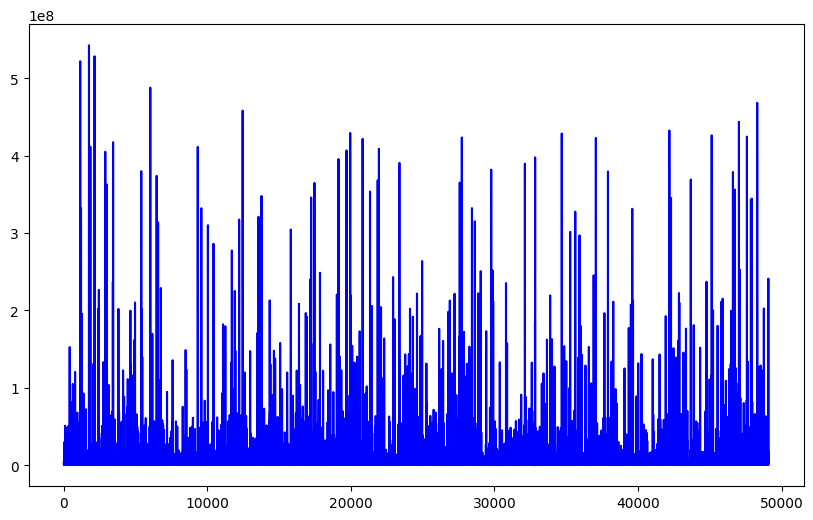

In [7]:
plt.figure(figsize=(10, 6))

# 繪製 y_test
plt.plot(y.values, label='True Values', color='blue')

# 繪製 y_pred
plt.plot(y_pred, label='Predicted Values', color='red')

# 添加標題和標籤
plt.title('Comparison of True and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# 顯示圖表
plt.show()